# Approach: Embedding + MLP

In [1]:
import optuna
from optuna.trial import Trial
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
import torch
from torch.utils.data import Dataset, DataLoader
from sentence_transformers import SentenceTransformer
from __future__ import annotations
import copy
import random
from typing import Callable, List, Sequence, Tuple
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt


/root/projects/ai-lab/feedback-prize/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load Data and Generate Embeddings

In [2]:
train = pd.read_csv("../../data/train.csv")
test = pd.read_csv("../../data/test.csv")

# IN KAGGLE:
#train = pd.read_csv("/kaggle/input/feedback-prize-english-language-learning/train.csv")
#test = pd.read_csv("/kaggle/input/feedback-prize-english-language-learning/test.csv")

sbert_model = SentenceTransformer("all-MiniLM-L6-v2")
sbert_model.max_seq_length = 512

# IN KAGGLE (UPLOAD sbert_model.zip TO NOTEBOOK AS DATASET FIRST):
#sbert_model = SentenceTransformer("/kaggle/input/sentence-bert")

embeddings = sbert_model.encode(train["full_text"].tolist(), show_progress_bar=True)
train["embedding"] = embeddings.tolist()

Batches: 100%|██████████| 123/123 [00:30<00:00,  3.99it/s]


### Define Dataset & Dataloader

In [3]:

class SBERTEmbeddingDataset(Dataset):
    def __init__(self, dataframe):
        self.embeddings = dataframe["embedding"].tolist()
        self.labels = dataframe[["cohesion", "syntax", "vocabulary", "phraseology", "grammar", "conventions"]].values.astype(float)

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        embedding = torch.tensor(self.embeddings[idx], dtype=torch.float)
        labels = torch.tensor(self.labels[idx], dtype=torch.float)
        return embedding, labels


In [4]:
dataset = SBERTEmbeddingDataset(train)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

### Define Function that builds Feed Forward Net

In [5]:
import torch.nn as nn

def make_model(
    hidden1: int = 512,
    hidden2: int = 256,
    hidden3: int = 128,
    dropout1: float = 0.4,
    dropout2: float = 0.3,
    dropout3: float = 0.2,
    in_dim: int = 384,
    out_dim: int = 6
):
    return nn.Sequential(
        nn.Linear(in_dim, hidden1),
        nn.ReLU(), nn.BatchNorm1d(hidden1), nn.Dropout(dropout1),

        nn.Linear(hidden1, hidden2),
        nn.ReLU(), nn.BatchNorm1d(hidden2), nn.Dropout(dropout2),

        nn.Linear(hidden2, hidden3),
        nn.ReLU(), nn.BatchNorm1d(hidden3), nn.Dropout(dropout3),

        nn.Linear(hidden3, out_dim)
    )


### Custom cost function

In [6]:
class MCRMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss(reduction='none')

    def forward(self, preds, targets):
        colwise_mse = self.mse(preds, targets).mean(dim=0) 
        colwise_rmse = torch.sqrt(colwise_mse + 1e-8)
        return colwise_rmse.mean()


### Define optuna (hyperparam tuning) objective

In [7]:
def objective(trial: Trial) -> float:
    hidden1 = trial.suggest_int("hidden1", 256, 768, step=64)
    hidden2 = trial.suggest_int("hidden2", 160, hidden1, step=64)
    hidden3 = trial.suggest_int("hidden3",  64, min(256, hidden2), step=32)

    drop1 = trial.suggest_float("drop1", 0.05, 0.4)
    drop2 = trial.suggest_float("drop2", 0.05, 0.4)
    drop3 = trial.suggest_float("drop3", 0.05, 0.4)

    lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
    wd = trial.suggest_float("weight_decay", 1e-8, 1e-3, log=True)

    bs = trial.suggest_categorical("batch_size", [16, 32, 64])
    epochs = trial.suggest_int("epochs", 12, 60)
    patience = trial.suggest_int("patience", 2, 9)

    model_fn = lambda: make_model(hidden1, hidden2, hidden3, drop1, drop2, drop3)

    fold_losses, _= cross_validate_kfold(
        dataset,
        model_fn,
        k           = 5,
        epochs      = epochs,
        lr          = lr,
        batch_size  = bs,
        weight_decay= wd,
        patience    = patience,
    )

    return float(np.mean(fold_losses)) 

### Train Net

In [8]:
# set seeds for reproduceable results

_SEED = 42
random.seed(_SEED)
np.random.seed(_SEED)
torch.manual_seed(_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(_SEED)

In [9]:
# abstraction for early stopping

class EarlyStopping:
    def __init__(self, patience: int = 5, min_delta: float = 1e-4) -> None:
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float("inf")
        self.best_state: dict[str, torch.Tensor] | None = None
        self._epochs_since_improve = 0
        self.stop = False

    def step(self, val_loss: float, model: nn.Module) -> None:
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            self._epochs_since_improve = 0
        else:
            self._epochs_since_improve += 1
            if self._epochs_since_improve >= self.patience:
                self.stop = True

In [10]:
# training function with cross validation

def cross_validate_kfold(
    dataset: torch.utils.data.Dataset,
    model_fn: Callable[[], nn.Module],
    *,
    k: int = 5,
    epochs: int = 10,
    lr: float = 1e-3,
    batch_size: int = 32,
    weight_decay: float = 1e-2,
    patience: int = 5,
) -> Tuple[List[float], List[Sequence[float]], List[nn.Module]]:
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    kf = KFold(n_splits=k, shuffle=True, random_state=_SEED)
    loss_fn = MCRMSELoss()

    fold_losses: List[float] = []
    models: List[nn.Module] = []

    plt.figure(figsize=(8, 5))

    for fold, (tr_idx, val_idx) in enumerate(kf.split(range(len(dataset))), 1):
        print(f"\nFold {fold}/{k}")

        train_loader = DataLoader(Subset(dataset, tr_idx), batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(Subset(dataset, val_idx), batch_size=batch_size)

        model = model_fn().to(device)
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=2)
        stopper = EarlyStopping(patience=patience)

        val_hist: List[float] = []

        for epoch in range(1, epochs + 1):
            # do training step
            model.train()
            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)
                loss = loss_fn(model(xb), yb)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # calculate validation score
            model.eval()
            val_sum = 0.0
            with torch.no_grad():
                for xb, yb in val_loader:
                    xb, yb = xb.to(device), yb.to(device)
                    val_sum += loss_fn(model(xb), yb).item() * xb.size(0)
            val_loss = val_sum / len(val_loader.dataset)
            val_hist.append(val_loss)

            print(f"Epoch {epoch}/{epochs}: val {val_loss:.5f}")

            # do scheduler step and check for early stopping
            scheduler.step(val_loss)
            stopper.step(val_loss, model)
            if stopper.stop:
                print("--Early stopping--")
                break

        model.load_state_dict(stopper.best_state)
        fold_losses.append(stopper.best_loss)
        models.append(copy.deepcopy(model).cpu())
        plt.plot(range(1, len(val_hist) + 1), val_hist, label=f"Fold {fold}")

    # plot training
    plt.title("Validation-Loss per Fold")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(alpha=.3)
    plt.tight_layout()
    plt.show()

    print(f"\n Average Val-Loss: {np.mean(fold_losses):.5f}")
    return fold_losses, models

In [11]:
# train final model without cross validation

def train_final_model(
    dataset: torch.utils.data.Dataset,
    model_fn: Callable[[], nn.Module],
    *,
    epochs: int = 10,
    lr: float = 1e-3,
    batch_size: int = 32,
    patience: int = 10,
    weight_decay: float = 1e-2,
    val_split: float = 0.1
) -> Tuple[nn.Module, List[float], List[float]]:

    device = "cuda" if torch.cuda.is_available() else "cpu"
    n_total = len(dataset)
    n_val = int(n_total * val_split)
    n_train = n_total - n_val

    indices = np.random.permutation(n_total)
    train_idx, val_idx = indices[:n_train], indices[n_train:]
    train_loader = DataLoader(torch.utils.data.Subset(dataset, train_idx), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(torch.utils.data.Subset(dataset, val_idx), batch_size=batch_size)

    model = model_fn().to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=2)
    loss_fn = MCRMSELoss()
    stopper = EarlyStopping(patience)

    val_hist: List[float] = []

    for epoch in range(1, epochs + 1):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            loss = loss_fn(model(xb), yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()
        val_running = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                val_running += loss_fn(model(xb), yb).item() * xb.size(0)
        val_loss = val_running / len(val_loader.dataset)
        val_hist.append(val_loss)
        scheduler.step(val_loss)
        stopper.step(val_loss, model)
        print(f"Epoch {epoch}/{epochs}: val {val_loss:.5f}")

        if stopper.stop:
            print("--Early stopping--")
            break

    model.load_state_dict(stopper.best_state)

    # Calculate RMSEs for individual labels
    y_true, y_pred = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            preds = model(xb).cpu()
            y_true.append(yb)
            y_pred.append(preds)

    y_true = torch.cat(y_true, dim=0)
    y_pred = torch.cat(y_pred, dim=0)
    per_label_rmse = torch.sqrt(torch.mean((y_true - y_pred) ** 2, dim=0))

    print("Per-label RMSEs:", per_label_rmse.tolist())

    return model.cpu(), val_hist

[I 2025-06-26 00:03:28,520] A new study created in memory with name: no-name-aa8deaa4-5cf3-4986-9124-56fa36bea9d2
/root/projects/ai-lab/feedback-prize/.venv/lib/python3.12/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [160, 448] and step=64, but the range is not divisible by `step`. It will be replaced by [160, 416].
  warnings.warn(



Fold 1/5
  Epoch 1/59: val 3.12540
  Epoch 2/59: val 3.12959
  Epoch 3/59: val 3.11128
  Epoch 4/59: val 3.11296
  Epoch 5/59: val 3.09659
  Epoch 6/59: val 3.10237
  Epoch 7/59: val 3.09701
  Epoch 8/59: val 3.08828
  Epoch 9/59: val 3.08853
  Epoch 10/59: val 3.08415
  Epoch 11/59: val 3.05958
  Epoch 12/59: val 3.05661
  Epoch 13/59: val 3.07707
  Epoch 14/59: val 3.04227
  Epoch 15/59: val 3.04945
  Epoch 16/59: val 3.04885
  Epoch 17/59: val 3.01916
  Epoch 18/59: val 3.01368
  Epoch 19/59: val 2.98899
  Epoch 20/59: val 2.97863
  Epoch 21/59: val 2.99459
  Epoch 22/59: val 2.95442
  Epoch 23/59: val 2.97327
  Epoch 24/59: val 2.97728
  Epoch 25/59: val 2.96720
  Epoch 26/59: val 2.90514
  Epoch 27/59: val 2.94893
  Epoch 28/59: val 2.93802
  Epoch 29/59: val 2.93845
  Epoch 30/59: val 2.89297
  Epoch 31/59: val 2.91387
  Epoch 32/59: val 2.88781
  Epoch 33/59: val 2.91202
  Epoch 34/59: val 2.91070
  Epoch 35/59: val 2.90196
  Epoch 36/59: val 2.90273
  Epoch 37/59: val 2.86989


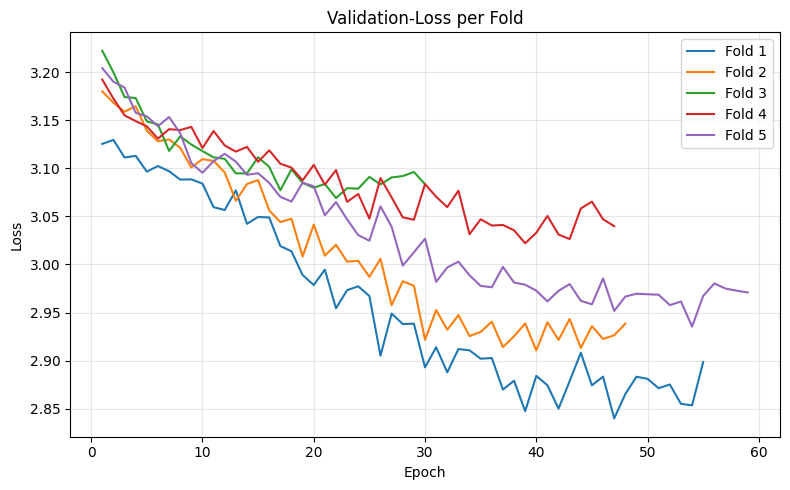

[I 2025-06-26 00:05:48,509] Trial 0 finished with value: 2.955410447916571 and parameters: {'hidden1': 448, 'hidden2': 416, 'hidden3': 224, 'drop1': 0.25953046946896285, 'drop2': 0.10460652415485279, 'drop3': 0.10459808211767094, 'lr': 1.3066739238053272e-05, 'weight_decay': 0.00021423021757741048, 'batch_size': 32, 'epochs': 59, 'patience': 8}. Best is trial 0 with value: 2.955410447916571.



 Average Val-Loss: 2.95541

Fold 1/5


/root/projects/ai-lab/feedback-prize/.venv/lib/python3.12/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [160, 320] and step=64, but the range is not divisible by `step`. It will be replaced by [160, 288].
  warnings.warn(


  Epoch 1/34: val 3.19978
  Epoch 2/34: val 3.22839
  Epoch 3/34: val 3.21336
  Epoch 4/34: val 3.21824
  Epoch 5/34: val 3.21613
  Epoch 6/34: val 3.22072
  Epoch 7/34: val 3.20525
  Epoch 8/34: val 3.20955
  Epoch 9/34: val 3.20598
--Early stopping--

Fold 2/5
  Epoch 1/34: val 3.16784
  Epoch 2/34: val 3.18783
  Epoch 3/34: val 3.21402
  Epoch 4/34: val 3.19846
  Epoch 5/34: val 3.20489
  Epoch 6/34: val 3.19829
  Epoch 7/34: val 3.18344
  Epoch 8/34: val 3.19395
  Epoch 9/34: val 3.19219
--Early stopping--

Fold 3/5
  Epoch 1/34: val 3.21092
  Epoch 2/34: val 3.18227
  Epoch 3/34: val 3.16759
  Epoch 4/34: val 3.16612
  Epoch 5/34: val 3.15441
  Epoch 6/34: val 3.15550
  Epoch 7/34: val 3.13946
  Epoch 8/34: val 3.12716
  Epoch 9/34: val 3.11689
  Epoch 10/34: val 3.12147
  Epoch 11/34: val 3.10690
  Epoch 12/34: val 3.10287
  Epoch 13/34: val 3.08395
  Epoch 14/34: val 3.08822
  Epoch 15/34: val 3.08483
  Epoch 16/34: val 3.06040
  Epoch 17/34: val 3.07037
  Epoch 18/34: val 3.045

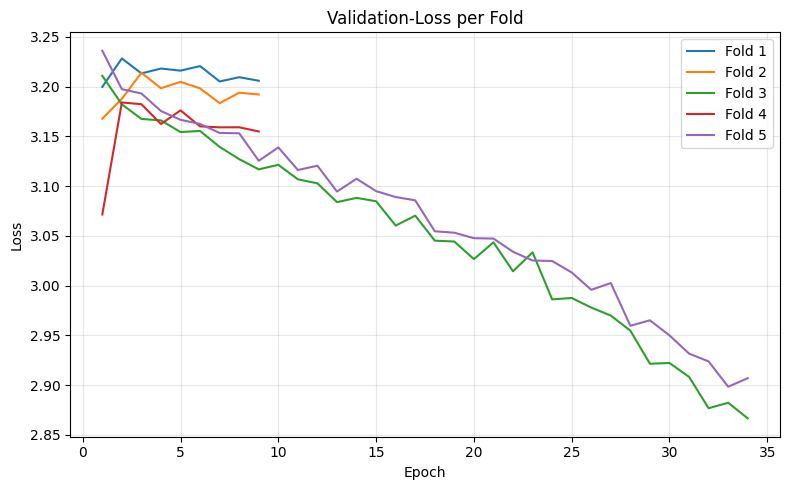

[I 2025-06-26 00:06:26,089] Trial 1 finished with value: 3.040824646231022 and parameters: {'hidden1': 320, 'hidden2': 160, 'hidden3': 64, 'drop1': 0.15648478503583824, 'drop2': 0.23366475107128326, 'drop3': 0.20118075652474054, 'lr': 3.8234752246751835e-05, 'weight_decay': 1.1462107403425014e-05, 'batch_size': 64, 'epochs': 34, 'patience': 8}. Best is trial 0 with value: 2.955410447916571.



 Average Val-Loss: 3.04082

Fold 1/5
  Epoch 1/16: val 3.21830
  Epoch 2/16: val 3.21206
  Epoch 3/16: val 3.20427
  Epoch 4/16: val 3.22170
  Epoch 5/16: val 3.19087
  Epoch 6/16: val 3.18277
  Epoch 7/16: val 3.16327
  Epoch 8/16: val 3.14118
  Epoch 9/16: val 3.14640
  Epoch 10/16: val 3.12126
  Epoch 11/16: val 3.15429
  Epoch 12/16: val 3.07963
  Epoch 13/16: val 3.01789
  Epoch 14/16: val 3.06609
  Epoch 15/16: val 3.03396
  Epoch 16/16: val 2.99933

Fold 2/5
  Epoch 1/16: val 3.17472
  Epoch 2/16: val 3.17687
  Epoch 3/16: val 3.13574
  Epoch 4/16: val 3.16319
  Epoch 5/16: val 3.13098
  Epoch 6/16: val 3.09785
  Epoch 7/16: val 3.10541
  Epoch 8/16: val 3.10536
  Epoch 9/16: val 3.05932
  Epoch 10/16: val 3.04954
  Epoch 11/16: val 3.07982
  Epoch 12/16: val 3.02215
  Epoch 13/16: val 3.01474
  Epoch 14/16: val 3.03235
  Epoch 15/16: val 3.02182
  Epoch 16/16: val 2.95326

Fold 3/5
  Epoch 1/16: val 3.21184
  Epoch 2/16: val 3.19734
  Epoch 3/16: val 3.18968
  Epoch 4/16: val 

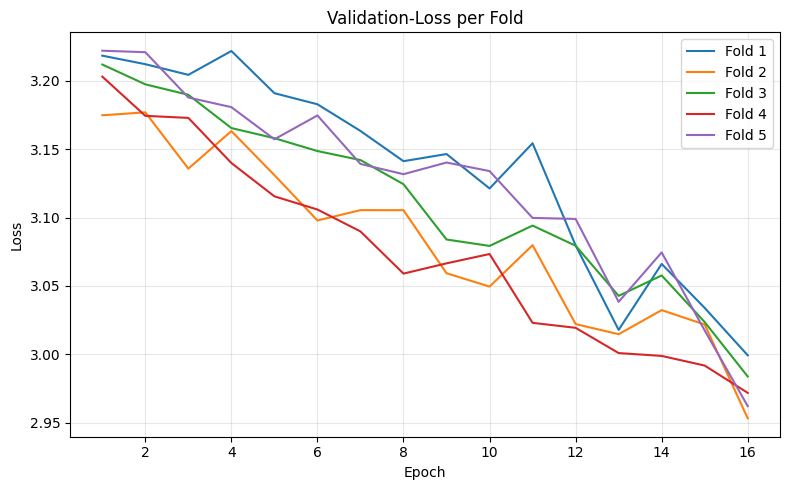

[I 2025-06-26 00:07:45,614] Trial 2 finished with value: 2.9741039739853736 and parameters: {'hidden1': 320, 'hidden2': 224, 'hidden3': 160, 'drop1': 0.0662576444519992, 'drop2': 0.26264069816550345, 'drop3': 0.10968344329055205, 'lr': 1.3492834268013232e-05, 'weight_decay': 0.000555172168524472, 'batch_size': 16, 'epochs': 16, 'patience': 7}. Best is trial 0 with value: 2.955410447916571.



 Average Val-Loss: 2.97410

Fold 1/5
  Epoch 1/59: val 3.09608
  Epoch 2/59: val 3.01053
  Epoch 3/59: val 2.84358
  Epoch 4/59: val 2.50776
  Epoch 5/59: val 2.08982
  Epoch 6/59: val 1.63317
  Epoch 7/59: val 0.93150
  Epoch 8/59: val 0.68286
  Epoch 9/59: val 0.65667
  Epoch 10/59: val 0.60779
  Epoch 11/59: val 0.59161
  Epoch 12/59: val 0.58421
  Epoch 13/59: val 0.58294
  Epoch 14/59: val 0.58516
  Epoch 15/59: val 0.59038
  Epoch 16/59: val 0.56824
  Epoch 17/59: val 0.56384
  Epoch 18/59: val 0.57226
  Epoch 19/59: val 0.56008
  Epoch 20/59: val 0.56021
  Epoch 21/59: val 0.56557
  Epoch 22/59: val 0.56188
  Epoch 23/59: val 0.55277
  Epoch 24/59: val 0.55336
  Epoch 25/59: val 0.55291
  Epoch 26/59: val 0.56072
  Epoch 27/59: val 0.55331
  Epoch 28/59: val 0.55602
  Epoch 29/59: val 0.55779
  Epoch 30/59: val 0.56469
  Epoch 31/59: val 0.55294
--Early stopping--

Fold 2/5
  Epoch 1/59: val 3.06433
  Epoch 2/59: val 2.95702
  Epoch 3/59: val 2.78245
  Epoch 4/59: val 2.50749
 

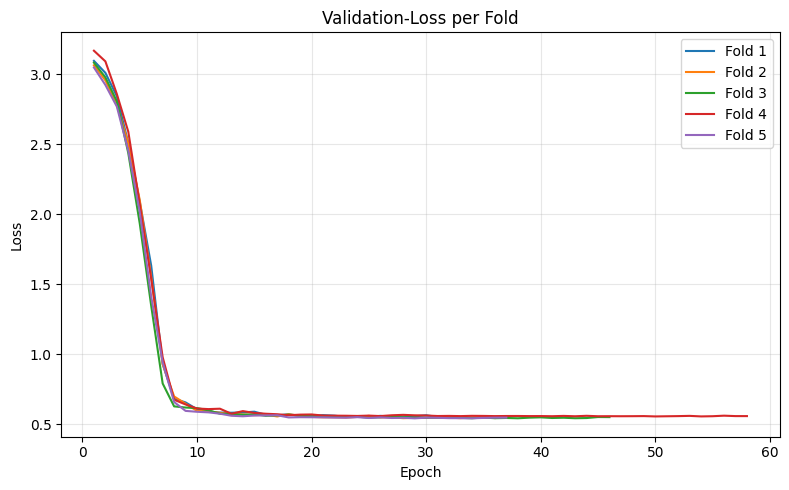

[I 2025-06-26 00:09:47,716] Trial 3 finished with value: 0.5478796457116528 and parameters: {'hidden1': 448, 'hidden2': 160, 'hidden3': 96, 'drop1': 0.06203598239032644, 'drop2': 0.36826214072757374, 'drop3': 0.14057299356000594, 'lr': 0.00021137059440645722, 'weight_decay': 3.618723330959616e-07, 'batch_size': 32, 'epochs': 59, 'patience': 8}. Best is trial 3 with value: 0.5478796457116528.



 Average Val-Loss: 0.54788

Fold 1/5


/root/projects/ai-lab/feedback-prize/.venv/lib/python3.12/site-packages/optuna/distributions.py:699: UserWarning: The distribution is specified by [160, 768] and step=64, but the range is not divisible by `step`. It will be replaced by [160, 736].
  warnings.warn(


  Epoch 1/29: val 3.29706
  Epoch 2/29: val 3.21031
  Epoch 3/29: val 3.20290
  Epoch 4/29: val 3.19048
  Epoch 5/29: val 3.17610
  Epoch 6/29: val 3.17281
  Epoch 7/29: val 3.16951
  Epoch 8/29: val 3.16779
  Epoch 9/29: val 3.16993
  Epoch 10/29: val 3.16070
  Epoch 11/29: val 3.15233
  Epoch 12/29: val 3.16350
  Epoch 13/29: val 3.12797
  Epoch 14/29: val 3.14183
  Epoch 15/29: val 3.14831
  Epoch 16/29: val 3.14624
  Epoch 17/29: val 3.13743
--Early stopping--

Fold 2/5
  Epoch 1/29: val 3.08082
  Epoch 2/29: val 3.12535
  Epoch 3/29: val 3.12751
  Epoch 4/29: val 3.14110
  Epoch 5/29: val 3.11236
--Early stopping--

Fold 3/5
  Epoch 1/29: val 3.27480
  Epoch 2/29: val 3.19937
  Epoch 3/29: val 3.19472
  Epoch 4/29: val 3.18630
  Epoch 5/29: val 3.18590
  Epoch 6/29: val 3.16923
  Epoch 7/29: val 3.15828
  Epoch 8/29: val 3.16714
  Epoch 9/29: val 3.15961
  Epoch 10/29: val 3.15365
  Epoch 11/29: val 3.13824
  Epoch 12/29: val 3.14228
  Epoch 13/29: val 3.12815
  Epoch 14/29: val 3

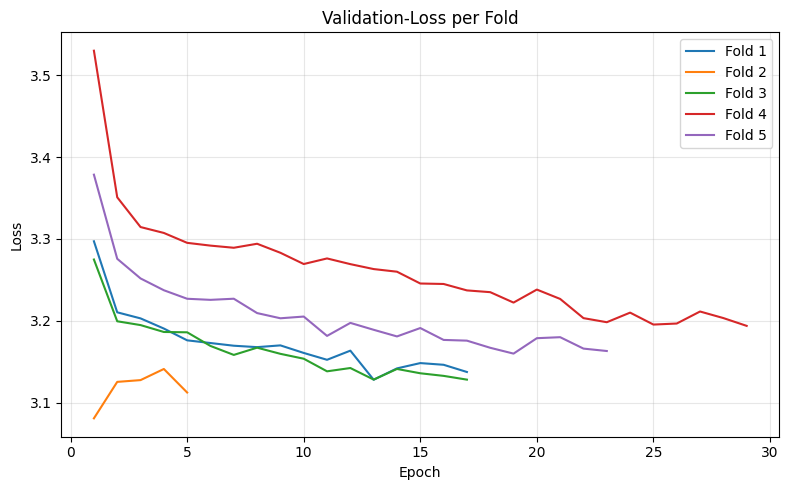

[I 2025-06-26 00:10:24,000] Trial 4 finished with value: 3.138114304687904 and parameters: {'hidden1': 768, 'hidden2': 672, 'hidden3': 192, 'drop1': 0.37265598225809093, 'drop2': 0.08097237571817183, 'drop3': 0.11859400184670083, 'lr': 1.2315571723666024e-05, 'weight_decay': 4.233032996527588e-07, 'batch_size': 64, 'epochs': 29, 'patience': 4}. Best is trial 3 with value: 0.5478796457116528.



 Average Val-Loss: 3.13811
Beste Parameter: {'hidden1': 448, 'hidden2': 160, 'hidden3': 96, 'drop1': 0.06203598239032644, 'drop2': 0.36826214072757374, 'drop3': 0.14057299356000594, 'lr': 0.00021137059440645722, 'weight_decay': 3.618723330959616e-07, 'batch_size': 32, 'epochs': 59, 'patience': 8}
Bester CV-Loss : 0.5478796457116528


In [24]:
study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(seed=_SEED),
    pruner = optuna.pruners.MedianPruner(n_startup_trials=5)
)

study.optimize(objective, n_trials=5, timeout=None)
print("Beste Parameter:", study.best_params)
print("Bester CV-Loss :", study.best_value)


### Train final model with best parameters

In [26]:
best = study.best_params
best_model_fn = lambda: make_model(
    best["hidden1"], best["hidden2"], best["hidden3"],
    best["drop1"],   best["drop2"],   best["drop3"],
)

final_model, _ = train_final_model(
    dataset,
    best_model_fn,
    epochs      = best["epochs"],
    lr          = best["lr"],
    batch_size  = best["batch_size"],
    weight_decay= best["weight_decay"],
    patience=study.best_params["patience"],
    val_split=0.1
)
torch.save(final_model.state_dict(), "best_model.pt")


Epoch 1/59: val 3.12281
Epoch 2/59: val 3.05226
Epoch 3/59: val 2.81974
Epoch 4/59: val 2.36959
Epoch 5/59: val 1.72931
Epoch 6/59: val 0.99597
Epoch 7/59: val 0.64800
Epoch 8/59: val 0.59936
Epoch 9/59: val 0.57560
Epoch 10/59: val 0.56082
Epoch 11/59: val 0.56348
Epoch 12/59: val 0.55793
Epoch 13/59: val 0.55318
Epoch 14/59: val 0.53869
Epoch 15/59: val 0.55161
Epoch 16/59: val 0.54745
Epoch 17/59: val 0.54656
Epoch 18/59: val 0.53577
Epoch 19/59: val 0.54572
Epoch 20/59: val 0.53791
Epoch 21/59: val 0.53927
Epoch 22/59: val 0.53553
Epoch 23/59: val 0.53660
Epoch 24/59: val 0.54073
Epoch 25/59: val 0.53344
Epoch 26/59: val 0.53650
Epoch 27/59: val 0.53295
Epoch 28/59: val 0.53340
Epoch 29/59: val 0.53227
Epoch 30/59: val 0.53137
Epoch 31/59: val 0.53327
Epoch 32/59: val 0.53781
Epoch 33/59: val 0.53620
Epoch 34/59: val 0.53444
Epoch 35/59: val 0.53685
Epoch 36/59: val 0.53452
Epoch 37/59: val 0.53785
Epoch 38/59: val 0.53592
--Early stopping--


### These fixed values are the best Hyperparameters as determined by our run on Kaggle

In [13]:
best_model_fn = lambda: make_model(
    384,  # hidden1
    160,  # hidden2
    128,  # hidden3
    0.3493036109543935,  # drop1
    0.3993247119525549,  # drop2
    0.2577739612640315   # drop3
)

final_model, _ = train_final_model(
    dataset,
    best_model_fn,
    epochs=35,
    lr=0.0005462166950529363,
    batch_size=16,
    weight_decay=0.0007062139394853876,
    patience=8,
    val_split=0.1
)

torch.save(final_model.state_dict(), "best_model.pt")


Epoch 1/35: val 1.96851
Epoch 2/35: val 0.63731
Epoch 3/35: val 0.60357
Epoch 4/35: val 0.58128
Epoch 5/35: val 0.55993
Epoch 6/35: val 0.56088
Epoch 7/35: val 0.54890
Epoch 8/35: val 0.53715
Epoch 9/35: val 0.53981
Epoch 10/35: val 0.54319
Epoch 11/35: val 0.54109
Epoch 12/35: val 0.53283
Epoch 13/35: val 0.52755
Epoch 14/35: val 0.52853
Epoch 15/35: val 0.53279
Epoch 16/35: val 0.52479
Epoch 17/35: val 0.52434
Epoch 18/35: val 0.52815
Epoch 19/35: val 0.52557
Epoch 20/35: val 0.52269
Epoch 21/35: val 0.52102
Epoch 22/35: val 0.51976
Epoch 23/35: val 0.51853
Epoch 24/35: val 0.52154
Epoch 25/35: val 0.52602
Epoch 26/35: val 0.51861
Epoch 27/35: val 0.51633
Epoch 28/35: val 0.51716
Epoch 29/35: val 0.52130
Epoch 30/35: val 0.51917
Epoch 31/35: val 0.52021
Epoch 32/35: val 0.52009
Epoch 33/35: val 0.51959
Epoch 34/35: val 0.52006
Epoch 35/35: val 0.51913
--Early stopping--
Per-label RMSEs: [0.5473132729530334, 0.5165388584136963, 0.4634733498096466, 0.5217432975769043, 0.575671494007110

### Generate Submission

In [27]:
embeddings = sbert_model.encode(test["full_text"].tolist(), show_progress_bar=True)
test["embedding"] = list(embeddings)

Batches: 100%|██████████| 1/1 [00:00<00:00,  5.76it/s]


In [28]:
class SBERTTestDataset(Dataset):
    def __init__(self, dataframe):
        self.ids = dataframe["text_id"].tolist()
        self.embeddings = dataframe["embedding"].tolist()

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        embedding = torch.tensor(self.embeddings[idx], dtype=torch.float)
        return self.ids[idx], embedding

In [29]:
test_dataset = SBERTTestDataset(test)
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
final_model.eval()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
final_model.to(device)

all_preds = []
text_ids = []

with torch.no_grad():
    for ids, xb in test_loader:
        xb = xb.to(device)
        preds = final_model(xb).cpu()
        all_preds.append(preds)
        text_ids.extend(ids)

predictions = torch.cat(all_preds).numpy()

submission_df = pd.DataFrame(predictions, columns=[
    "cohesion", "syntax", "vocabulary", "phraseology", "grammar", "conventions"
])

submission_df.insert(0, "text_id", text_ids)
submission_df.to_csv("submission.csv", index=False)